<a href="https://colab.research.google.com/github/tianyuanshao/MarchMadnessClassifier/blob/main/CBProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Import libraries 
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn as sk
import sklearn.metrics as skm
from sklearn.decomposition import PCA             
from sklearn.preprocessing import normalize       
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
# Import Libraries for Deep Learning
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer
from pprint import pprint
import warnings

In [ ]:
# Bayes Optimization Library: https://github.com/fmfn/BayesianOptimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

In [ ]:
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [ ]:
# Import datasets 

# ALL YEARS
cbb = pd.read_csv('/content/drive/MyDrive/CS271P/FinalProject/Datafiles/cbb.csv')

In [ ]:
# EDA: Basics
cbb.head(5)     # Obtain first 5 rows
len(cbb['CONF'].unique())   # Obtain distinct number of CONF variables (Athletic conference of school participation)
len(cbb.columns)    # Obtain total number of variables 
len(cbb.index)      # Obtain total number of rows
cbb.dtypes          # Types per columns
cbb.shape           # Dimensions of data frame

(2455, 24)

In [ ]:
# Check for duplicate rows
cbb_duplicated = cbb[cbb.duplicated()]
cbb_duplicated

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR


In [ ]:
# EDA: Transforming Null Values/New Variable Assignments
cbb.isnull().sum()    # Obtain number of null values for each variable

# 1 = TRUE, 0 = FALSE
cbb['MAKE'] = np.where(pd.isnull(cbb.SEED), 0, 1)   # Create new bool variable MAKE for team making it into tournament 

len(cbb.columns)

25

In [ ]:
# EDA: Transforming Wins Over Games Variables to Win Percentages
cbb.insert(2, 'WP', cbb.apply(lambda x:x['W']/x['G'], axis = 1))
cbb

,TEAM,CONF,WP,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,MAKE
0,North Carolina,ACC,0.825000,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016,1
1,Wisconsin,B10,0.900000,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015,1
2,Michigan,B10,0.825000,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018,1
3,Texas Tech,B12,0.815789,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019,1
4,Gonzaga,WCC,0.948718,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2450,Michigan St.,B10,0.742857,35,26,111.4,87.8,0.9392,50.6,44.5,20.8,19.2,36.1,27.6,36.6,32.4,50.4,44.3,34.1,30.1,64.4,6.7,S16,3.0,2013,1
2451,Arizona,P12,0.771429,35,27,114.4,92.2,0.9229,52.5,46.6,19.5,19.8,35.0,26.7,37.4,32.9,50.6,43.4,37.1,35.8,66.8,4.6,S16,6.0,2013,1
2452,Oregon,P12,0.756757,37,28,104.8,88.6,0.8728,49.3,46.4,21.4,22.0,35.8,27.2,38.4,33.3,49.1,44.9,33.3,33.4,69.2,2.9,S16,12.0,2013,1
2453,La Salle,A10,0.705882,34,24,112.0,96.2,0.8516,51.9,49.3,17.1,21.3,29.0,34.2,31.3,28.5,49.3,50.6,37.7,30.2,66.0,0.3,S16,13.0,2013,1


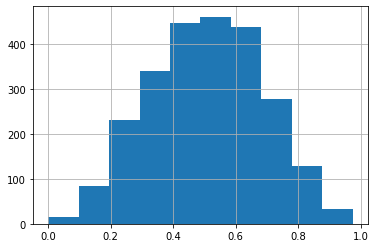

In [ ]:
# EDA: Numerical Variables
cbbnum = cbb.drop(columns = ['YEAR', 'CONF', 'POSTSEASON', 'SEED', 'MAKE'])  # Include only columns with numerical values
cbbnum.describe()       # Summary statistics for numerical variables 
cbbnum.WP.hist()
#cbbnum.G.hist()
#cbbnum.W.hist()
#cbbnum.ADJOE.hist()
#cbbnum.ADJDE.hist()
#cbbnum.BARTHAG.hist()
#cbbnum.EFG_O.hist()
#cbbnum.EFG_D.hist()
#cbbnum.TOR.hist()
#cbbnum.TORD.hist()
#cbbnum.ORB.hist()
#cbbnum.DRB.hist()
#cbbnum.FTR.hist()
#cbbnum.FTRD.hist()
#cbbnum.2P_O.hist()
#cbbnum.2P_D.hist()
#cbbnum.3P_O.hist()
#cbbnum.3P_D.hist()
#cbbnum.ADJ_T.hist()
#cbbnum.WAB.hist()

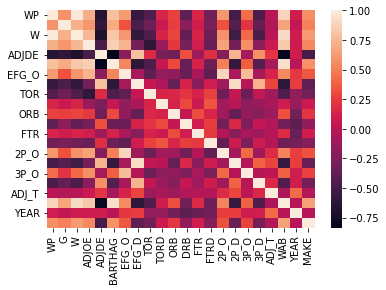

In [ ]:
# EDA: Heatmap
cbbnew = cbb.drop(columns = ['SEED', 'POSTSEASON'])     # Drop columns with null values (already transformed)
len(cbbnew.columns)
cbbnew.isnull().sum()     # Check for null values

# Can customize correlation method (Pearson by default): https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
sb.heatmap(cbbnew.corr())    # Plot heatmap for database

In [ ]:
# EDA: Mean Statistics for Teams
byteam = cbbnew.groupby('TEAM')

byteam.mean()

byteam.MAKE.sum().sort_values(ascending = False)
byteam.WP.mean().sort_values(ascending = False)




TEAM
Gonzaga                   0.872512
Villanova                 0.818782
Virginia                  0.806197
Wichita St.               0.795254
Duke                      0.792960
                            ...   
Alabama A&M               0.243395
Maine                     0.211023
San Jose St.              0.206240
Mississippi Valley St.    0.191263
Chicago St.               0.174548
Name: WP, Length: 355, dtype: float64

In [ ]:
# EDA: Creating Training Data
y = cbb['MAKE']         # Set target value to FINALS
cbb['MAKE'].value_counts()
cbb
x = cbb.drop(columns = ['G', 'W', 'MAKE', 'POSTSEASON', 'SEED'], axis = 1)



In [ ]:
# Find int types
x.dtypes

# Drop non-float types
x.drop(columns = ['TEAM', 'CONF','YEAR', 'WAB'], inplace=True)

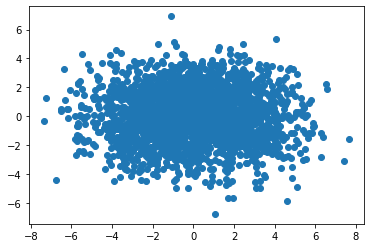

In [ ]:
#PCA for Dimensionality Reduction / Explained Variance of columns               
A = x
pca = PCA(n_components=17) 
B = pca.fit_transform(sk.preprocessing.scale(A))      # Scale data as each variable has different range
plt.scatter(B[:,0], B[:,1])


#print(pca.explained_variance_)
#print(abs(pca.components_))
#print(B)

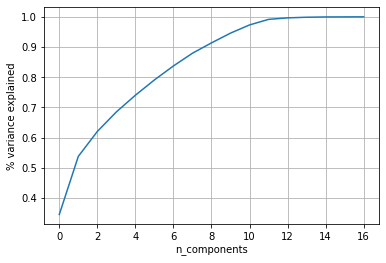

In [ ]:
# Number of Principal Components    

# https://towardsdatascience.com/dimensionality-reduction-can-pca-improve-the-performance-of-a-classification-model-d4e34194c544

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()


In [ ]:
# number of components to capture >50% is 2 and > 90% variance is 8

# https://towardsdatascience.com/pca-is-not-feature-selection-3344fb764ae6  

pca = PCA(n_components = 8)
B = pca.fit_transform(sk.preprocessing.scale(A))

# most important features for each PC

num_pc = pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(num_pc)]
                         
feature_names = list(x.columns)
important_names = [feature_names[most_important[i]] for i in range(num_pc)]

dic_feature = {'PC{}'.format(i+1):important_names[i] for i in range(num_pc)}

feature_pca = pd.DataFrame(dic_feature.items())

print(feature_pca)
print(x.var())

     0        1
0  PC1  BARTHAG
1  PC2    EFG_D
2  PC3     TORD
3  PC4     TORD
4  PC5    ADJ_T
5  PC6      TOR
6  PC7      DRB
7  PC8      ORB
WP          0.032301
ADJOE      54.419841
ADJDE      43.630227
BARTHAG     0.065661
EFG_O       9.878833
EFG_D       8.641261
TOR         4.370586
TORD        4.847699
ORB        17.092699
DRB         9.931664
FTR        27.539614
FTRD       39.011270
2P_O       11.454624
2P_D       11.159247
3P_O        7.780941
3P_D        5.835928
ADJ_T      10.742807
dtype: float64


In [ ]:
# Splitting into Test/Train Data (70% Train 20% Test 10% Validation)
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, test_size = 0.20,stratify = y, random_state = 7)
B_train, B_test, B_y_train, B_y_test = sk.model_selection.train_test_split(B, y, test_size = 0.20, random_state = 7)
# Splitting into Train/Validation Data
x_train, x_val, y_train, y_val = sk.model_selection.train_test_split(x_train, y_train, test_size = 0.125, random_state = 7)
B_train, B_val, B_y_train, B_y_val = sk.model_selection.train_test_split(B_train, B_y_train, test_size = 0.125, random_state = 7)


In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter = 10000, random_state= 7) 
cv = cross_val_score(lr, x, y, cv = 5)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (cv.mean() * 100.0, cv.std() * 2))

### Model with Split Train/Test Data
lr.fit(x_train, y_train)
lr_probs = lr.predict_proba(x_test)          ## for ROC Curves
lr_probs = lr_probs[:,1]                     ## Keep probabilities for value with 1 only
preds = lr.predict(x_test)
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# K-Fold Cross Validation Approach 
cv = KFold(n_splits = 5, random_state = 1, shuffle = True)
accuracy = cross_val_score(lr, x, y, scoring = 'accuracy', cv = cv, n_jobs = -1)
print('Accuracy: %.3f%%  (+/- %.3f%%)' % (np.mean(accuracy) * 100.0, np.std(accuracy) ))



Accuracy: 90.22% (+/- 0.06%)
Accuracy: 90.43%
Accuracy: 90.672%  (+/- 0.009%)


In [ ]:
#### Model with Transformed B_Train/Test Data                       ## Same accuracy with PCA (89-92%)
lr_B = LogisticRegression(max_iter = 10000, random_state=7)
cv = cross_val_score(lr_B, B, y, cv = 5)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (cv.mean() * 100.0, cv.std() * 2))

### Model with Split Train/Test Data
lr_B.fit(B_train, B_y_train)
lr_probs_B = lr_B.predict_proba(B_test)          ## for ROC Curves
lr_probs_B = lr_probs_B[:,1]                     ## Keep probabilities for value with 1 only
preds_lr_B = lr_B.predict(B_test)
accuracy= accuracy_score(B_y_test, preds_lr_B)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# K-Fold Cross Validation Approach 
cv = KFold(n_splits = 5, random_state = 7, shuffle = True)
accuracy = cross_val_score(lr_B, B, y, scoring = 'accuracy', cv = cv, n_jobs = -1)
print('Accuracy: %.3f%%  (+/- %.3f%%)' % (np.mean(accuracy) * 100.0, np.std(accuracy) ))



Accuracy: 89.53% (+/- 0.06%)
Accuracy: 91.85%
Accuracy: 90.591%  (+/- 0.011%)


In [ ]:
# Logistic Regression Parameter Tuning

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']     
penalty = ['none','l1','l2','elasticnet']
C_lr = [100, 10, 1, 0.1, 0.01]

param_grid_lr = dict(C = C_lr, penalty = penalty, solver = solvers)

grid_search_lr = GridSearchCV(lr, param_grid = param_grid_lr, n_jobs = -1, error_score = 0 )
grid_search_lr.fit(x_train,y_train)

GridSearchCV(error_score=0,
             estimator=LogisticRegression(max_iter=10000, random_state=7),
             n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [ ]:
#Parameter Tuning for PCA

grid_search_lr_B = GridSearchCV(lr_B, param_grid = param_grid_lr, n_jobs = -1, error_score = 0 )
grid_search_lr_B.fit(B_train,B_y_train)

GridSearchCV(error_score=0,
             estimator=LogisticRegression(max_iter=10000, random_state=7),
             n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [ ]:
## Best Model from Hyper Parameters

print(grid_search_lr.best_params_)
print(grid_search_lr.best_estimator_)

grid_pred_lr = grid_search_lr.predict(x_test)           
accuracy_grid_lr = accuracy_score(y_test, grid_pred_lr)
print("Accuracy: %.2f%%" % (accuracy_grid_lr * 100))

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=10, max_iter=10000, penalty='l1', random_state=7,
                   solver='liblinear')
Accuracy: 92.06%


In [ ]:
## Best Model from Hyper Parameters for B data

print(grid_search_lr_B.best_params_)
print(grid_search_lr_B.best_estimator_)

grid_pred_lr_B = grid_search_lr_B.predict(B_test)           
accuracy_grid_lr_B = accuracy_score(B_y_test, grid_pred_lr_B)
print("Accuracy: %.2f%%" % (accuracy_grid_lr_B * 100))

{'C': 100, 'penalty': 'none', 'solver': 'newton-cg'}
LogisticRegression(C=100, max_iter=10000, penalty='none', random_state=7,
                   solver='newton-cg')
Accuracy: 91.85%


In [ ]:
# Logistic Regression Model Evaluation
# https://towardsdatascience.com/should-i-look-at-precision-recall-or-specificity-sensitivity-3946158aace1

##### Confusion Matrix for Parameter Optimization
cm = skm.confusion_matrix(y_test, grid_pred_lr)
print('Confusion Matrix:', cm)

##### Confusion Matrix for Transformed B Data   
#cm = skm.confusion_matrix(B_y_test, preds_lr_B)
#print('Confusion Matrix:', cm)


##### Confusion Matrix          Baseline
#cm = skm.confusion_matrix(y_test, preds)
#print('Confusion Matrix:', cm)

# Senstivity
# TP/(TP + FN)
sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
print('Sensitivity: ', sensitivity )

# Specificity
# TN/(TN + FP)
specificity = cm[0,0]/(cm[0,0] + cm[0,1])
print('Specificity: ', specificity)

# Precision
# TP/(TP + FP)
precision = cm[1,1]/(cm[1,1] + cm[0,1])
print('Precision: ', precision)

# Recall
# TP/(TP + FN)
recall = cm[1,1]/(cm[1,1] + cm[1,0])
print('Recall: ', recall)

# F1 Score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
f1 = 2 * (precision * recall) / (precision + recall)
print('F1 Score: ', f1)

Confusion Matrix: [[382  14]
 [ 25  70]]
Sensitivity:  0.7368421052631579
Specificity:  0.9646464646464646
Precision:  0.8333333333333334
Recall:  0.7368421052631579
F1 Score:  0.782122905027933


**CONFUSION MATRIX FOR BEST PARAMETERS**

Confusion Matrix: [[382  14]
 [ 25  70]]


---


Sensitivity:  0.7368421052631579


---


Specificity:  0.9646464646464646


---


Precision:  0.8333333333333334


---


Recall:  0.7368421052631579


---


F1 Score:  0.782122905027933



**PCA CONFUSION MATRIX**

Confusion Matrix: 
[[374  19]
 [ 38  60]]

---


Sensitivity:  0.7363636363636363

---


Specificity:  0.9711286089238845

---


Precision:  0.8804347826086957

---



Recall:  0.7363636363636363

---

F1 Score:  0.8019801980198019

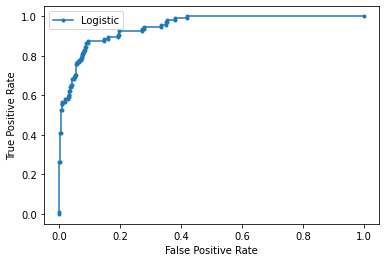

In [ ]:
# Logistic Regression ROC Curve 
lr_fpr, lr_tpr, _ = skm.roc_curve(y_test, lr_probs)
plt.plot(lr_fpr, lr_tpr, marker='.', label = 'Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
# Hyperparameter tweaking for XGBoost using Bayesian Optimization
##### https://aiinpractice.com/xgboost-hyperparameter-tuning-with-bayesian-optimization/
##### https://github.com/fmfn/BayesianOptimization/blob/master/examples/sklearn_example.py

# Define function that returns the mean of cross validation scores per hyperparameters passed in
def xgboost_crossval(n_estimators, max_depth, learning_rate, gamma):

  # Cast max_depth and n_estimators to integers
  max_depth = int(max_depth)
  n_estimators = int(n_estimators)

  # Train model and calculate cross validation score
  xg_class = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, gamma=gamma, seed = 7)
  accuracy = cross_val_score(xg_class, x_train, y_train, scoring='accuracy', cv=5) 
  
  # Return mean of cross_val_scores
  return np.mean(accuracy)


# Call BayesionOptimization to check scores for various hyperparameters
optimizer = BayesianOptimization(
            f=xgboost_crossval,
            pbounds={'n_estimators': (5, 100),
                       'max_depth': (2,10),
                       'learning_rate': (0.01, 1.0),
                       'gamma': (1, 5)},
            random_state=7)

optimizer.maximize(n_iter=10)
print('Optimal XGBoost hyperparameters per BayesianOptimization: ', optimizer.max)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.9051   |  1.305    |  0.7821   |  5.507    |  73.73    |
|  2        |  0.9069   |  4.912    |  0.5431   |  6.009    |  11.84    |
|  3        |  0.9069   |  2.074    |  0.5049   |  7.434    |  81.36    |
|  4        |  0.9109   |  2.524    |  0.07528  |  4.305    |  91.41    |
|  5        |  0.9086   |  1.854    |  0.4576   |  9.45     |  7.365    |
|  6        |  0.9034   |  1.77     |  0.3848   |  7.482    |  68.23    |
|  7        |  0.9069   |  5.0      |  0.01     |  2.0      |  100.0    |
|  8        |  0.9104   |  1.0      |  0.4264   |  9.542    |  92.48    |
|  9        |  0.8964   |  5.0      |  1.0      |  8.243    |  90.27    |
|  10       |  0.9011   |  4.557    |  0.9928   |  3.356    |  19.56    |
|  11       |  0.9069   |  2.191    |  0.3757   |  3.399    |  33.46    |
|  12       |  0.9092   |  3.081    | 

In [ ]:
# XGBoost
# https://github.com/dmlc/xgboost/blob/master/python-package/xgboost/sklearn.py
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
# https://github.com/isakbosman/CS271P/blob/952919dab5f2fef80a38a4c8a614da7f5e63be5f/nbs/CS271P_Lab_2_XGBoost_Heart_Disease.ipynb

#XGBoost Model w/ tweaked Hyperparameters

# Hyperparameters calculated with BayesianOptimization
xg_class = xgb.XGBClassifier(max_depth=int(optimizer.max['params']['max_depth']), 
                             learning_rate=optimizer.max['params']['learning_rate'],
                             n_estimators = int(optimizer.max['params']['n_estimators']),
                             gamma=optimizer.max['params']['gamma'], seed=7)

xg_class.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=4)

preds = xg_class.predict(x_test)

accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Baseline w/ Cross Validation
xg_classcv = xgb.XGBClassifier(seed=7)
xgcv = cross_val_score(xg_classcv, x, y, cv = 5)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (xgcv.mean() * 100.0, xgcv.std() * 2))

# K-Fold Cross Validation Approach 
cv = KFold(n_splits = 5, random_state = 7, shuffle = True)
accuracy = cross_val_score(xg_classcv, x, y, scoring = 'accuracy', cv = cv, n_jobs = -1)
print('Accuracy: %.3f%%  (+/- %.3f%%)' % (np.mean(accuracy) * 100.0, np.std(accuracy) ))



[0]	validation_0-error:0.073341	validation_1-error:0.089431
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 4 rounds.
[1]	validation_0-error:0.06752	validation_1-error:0.093496
[2]	validation_0-error:0.06752	validation_1-error:0.105691
[3]	validation_0-error:0.068102	validation_1-error:0.101626
[4]	validation_0-error:0.066938	validation_1-error:0.089431
Stopping. Best iteration:
[0]	validation_0-error:0.073341	validation_1-error:0.089431

Accuracy: 90.43%
Accuracy: 90.63% (+/- 0.07%)
Accuracy: 91.405%  (+/- 0.008%)


In [ ]:
#Leave-One-Out-Cross-Validation -- Source: https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/
loocv = sk.model_selection.LeaveOneOut()

accuracy = cross_val_score(xg_class, x, y, scoring='accuracy', cv=loocv, n_jobs=-1)
print('Accuracy: %.3f%%  (+/- %.3f%%)' % (np.mean(accuracy) * 100.0, np.std(accuracy) ))

Accuracy: 91.527%  (+/- 0.278%)


In [ ]:
## Baseline w/ PCA Data

xg_class_B = xgb.XGBClassifier(seed=7)
xg_class_B.fit(B_train, B_y_train, eval_set=[(B_train, B_y_train), (B_val, B_y_val)], early_stopping_rounds=4)

preds_B = xg_class_B.predict(B_test)

accuracy_B = accuracy_score(B_y_test, preds_B)
print("Accuracy: %.2f%%" % (accuracy_B * 100.0))

[0]	validation_0-error:0.09837	validation_1-error:0.130081
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 4 rounds.
[1]	validation_0-error:0.090803	validation_1-error:0.121951
[2]	validation_0-error:0.089057	validation_1-error:0.121951
[3]	validation_0-error:0.086729	validation_1-error:0.134146
[4]	validation_0-error:0.086147	validation_1-error:0.138211
[5]	validation_0-error:0.087893	validation_1-error:0.138211
Stopping. Best iteration:
[1]	validation_0-error:0.090803	validation_1-error:0.121951

Accuracy: 89.61%


In [ ]:
# XGBoost Model Evaluation
#Confusion Matrix for PCA
#cm = skm.confusion_matrix(B_y_test, preds_B)
#print('Confusion Matrix:', cm)


# Confusion Matrix
cm = skm.confusion_matrix(y_test, preds)
print('Confusion Matrix:', cm)

# Senstivity
# TP/(TP + FN)
sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
print('Sensitivity: ', sensitivity )

# Specificity
# TN/(TN + FP)
specificity = cm[0,0]/(cm[0,0] + cm[0,1])
print('Specificity: ', specificity)

# Precision
# TP/(TP + FP)
precision = cm[1,1]/(cm[1,1] + cm[0,1])
print('Precision: ', precision)

# Recall
# TP/(TP + FN)
recall = cm[1,1]/(cm[1,1] + cm[1,0])
print('Recall: ', recall)

# F1 Score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
f1 = 2 * (precision * recall) / (precision + recall)
print('F1 Score: ', f1)

Confusion Matrix: [[376  20]
 [ 27  68]]
Sensitivity:  0.7157894736842105
Specificity:  0.9494949494949495
Precision:  0.7727272727272727
Recall:  0.7157894736842105
F1 Score:  0.7431693989071039


**Confusion Matrix:  XGBoost with Tuned HyperParameters**



---



Sensitivity:  0.7157894736842105


---


Specificity:  0.9494949494949495


---


Precision:  0.7727272727272727

---

Recall:  0.7157894736842105

---

F1 Score: 0.7431693989071039


**PCA CM Data for XGBOOST**

Confusion Matrix: [[371  10]
 [ 35  75]]


---


Sensitivity:  0.6818181818181818


---


Specificity:  0.973753280839895


---


Precision:  0.8823529411764706


---


Recall:  0.6818181818181818


---


F1 Score:  0.7692307692307693

In [ ]:
# Support Vector Machine
svm = SVC(random_state=7) 
cv = cross_val_score(svm, x, y, cv = 5)
print(cv)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (cv.mean() * 100.0, cv.std() * 2))

svm.fit(x_train, y_train)
preds = svm.predict(x_test)
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


[0.92668024 0.89613035 0.86558045 0.85743381 0.90020367]
Accuracy: 88.92% (+/- 0.05%)
Accuracy: 90.84%



*   Baseline Model Accuracy (w/ Cross Validation): 90.22% +/- 0.07%
*   Baseline: 91.65





In [ ]:
# PCA svm
svm_B = SVC(random_state=7)
cv = cross_val_score(svm_B, B, y, cv=5)
print(cv)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (cv.mean() * 100.0, cv.std() * 2))

svm_B.fit(B_train, B_y_train)
preds_B = svm_B.predict(B_test)
accuracy_B = accuracy_score(B_y_test, preds_B)
print("Accuracy: %.2f%%" % (accuracy_B * 100))

[0.93482688 0.93482688 0.84725051 0.86150713 0.88594705]
Accuracy: 89.29% (+/- 0.07%)
Accuracy: 90.84%


In [ ]:
#Parameter Tuning for Support Vector Machine

kernel = ['polynomial','linear','sigmoid']
C = [100, 50, 10, 5, 1, 0.1]
gamma = ['scale']
param_grid = dict(C=C, gamma = gamma, kernel = kernel)
grid_search = GridSearchCV(svm, param_grid = param_grid, n_jobs = -1, error_score = 0)
grid_search.fit(x_train,y_train)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

grid_pred = grid_search.predict(x_test)           
accuracy_grid = accuracy_score(y_test, grid_pred)
print("Accuracy: %.2f%%" % (accuracy_grid * 100))

{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
SVC(C=100, kernel='linear', random_state=7)
Accuracy: 91.45%


In [ ]:
#Parameter Tuning for Support Vector Machine PCA


grid_search_B = GridSearchCV(svm_B, param_grid = param_grid, n_jobs = -1, error_score = 0 )
grid_search_B.fit(B_train,B_y_train)

print(grid_search_B.best_params_)
print(grid_search_B.best_estimator_)

grid_pred_B = grid_search_B.predict(B_test)           
accuracy_grid_B = accuracy_score(B_y_test, grid_pred_B)
print("Accuracy: %.2f%%" % (accuracy_grid_B * 100))

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
SVC(C=0.1, kernel='linear', random_state=7)
Accuracy: 91.65%


LINEAR KERNEL GIVES 92.26% on this seed?
RBF KERNEL Accuracy: 90.63%

In [ ]:
# Support Vector Machine Model Evaluation
# Confusion Matrix

#cm = skm.confusion_matrix(y_test, grid_pred)
#print('Confusion Matrix:', cm)

#Confusion Matrix for PCA B Data
#cm = skm.confusion_matrix(B_y_test, preds_B)
#print('Confusion Matrix:', cm)

# Confusion Matrix
cm = skm.confusion_matrix(y_test, preds)
print('Confusion Matrix:', cm)

# Senstivity
# TP/(TP + FN)
sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
print('Sensitivity: ', sensitivity )

# Specificity
# TN/(TN + FP)
specificity = cm[0,0]/(cm[0,0] + cm[0,1])
print('Specificity: ', specificity)

# Precision
# TP/(TP + FP)
precision = cm[1,1]/(cm[1,1] + cm[0,1])
print('Precision: ', precision)

# Recall
# TP/(TP + FN)
recall = cm[1,1]/(cm[1,1] + cm[1,0])
print('Recall: ', recall)

# F1 Score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
f1 = 2 * (precision * recall) / (precision + recall)
print('F1 Score: ', f1)

Confusion Matrix: [[390   6]
 [ 39  56]]
Sensitivity:  0.5894736842105263
Specificity:  0.9848484848484849
Precision:  0.9032258064516129
Recall:  0.5894736842105263
F1 Score:  0.7133757961783439


**Confusion Matrix for Tuned HyperParameters**

Confusion Matrix: [[379  17]
 [ 25  70]]


---


Sensitivity:  0.7368421052631579


---


Specificity:  0.9570707070707071


---


Precision:  0.8045977011494253


---


Recall:  0.7368421052631579


---


F1 Score:  0.7692307692307692

**PCA Confusion Matrix for SVM** 

Confusion Matrix: [[371  10]
 [ 35  75]]


---


Sensitivity:  0.6818181818181818


---


Specificity:  0.973753280839895


---


Precision:  0.8823529411764706


---


Recall:  0.6818181818181818


---


F1 Score:  0.7692307692307693

In [ ]:
# Set LeakyReLU 
LeakyReLU = LeakyReLU(alpha=0.1)

In [ ]:
# Make scorer accuracy
score_acc = make_scorer(accuracy_score)

In [ ]:
# Convert to int
y = LabelEncoder().fit_transform(y)
y_test = LabelEncoder().fit_transform(y_test)
y_train = LabelEncoder().fit_transform(y_train)
y_val = LabelEncoder().fit_transform(y_val)

In [ ]:
# Hyperparameter Tuning w/ BaysianOptimization for Deep Learning
# https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/
# Create function
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs, layers1, layers2,
             normalization, dropout, dropout_rate):
    #layeropt = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Ftrl']    # https://keras.io/api/optimizers/
    #denseopt = {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
    #             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
    #            'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    layeropt = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    denseopt= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    actfx = ['relu', LeakyReLU, 'sigmoid', 'tanh', 'selu', 'elu']   # https://keras.io/api/layers/activations/
    #actfx = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential', LeakyReLU]
    neurons = round(neurons)
    activation = actfx[round(activation)]
    optimizer = denseopt[layeropt[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=17, activation=activation))   # Input Layer
        if normalization > 0.5:
          nn.add(BatchNormalization())
        for i in range(layers1):
          nn.add(Dense(neurons, activation=activation))     # Hidden layer(s)
        if dropout > 0.5:
          nn.add(Dropout(dropout_rate, seed = 7))     # Dropout Layer
        for i in range(layers2):
            nn.add(Dense(neurons, activation = activation))   # Hidden layer(s)
        nn.add(Dense(1, activation='sigmoid'))    # Output Layer
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    pprint(vars(nn))
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    accuracy = cross_val_score(nn, x_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return accuracy

In [ ]:
# Set paramaters
params_nn ={
    'neurons': (2, 50), 
    'activation':(0, 5),
    'optimizer':(0,8),
    'learning_rate':(0.01, 1),
    'batch_size':(20, 200), 
    'epochs':(20, 100),
    'layers1':(1,3), # Hidden layer
    'layers2':(1,3), # Hidden layer
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}

# Run Bayesian Optimization
mlp_optimizer = BayesianOptimization(nn_cl_bo, params_nn, random_state = 7)
mlp_optimizer.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
{'build_fn': <function nn_cl_bo.<locals>.nn_cl_fun at 0x7fb8eacd5320>,
 'sk_params': {'batch_size': 160, 'epochs': 98, 'verbose': 0}}
|  1        |  0.9063   |  0.3815   |  160.4    |  0.4384   |  0.217    |  98.24    |  2.077    |  2.002    |  0.08133  |  14.89    |  0.4999   |  5.434    |
{'build_fn': <function nn_cl_bo.<locals>.nn_cl_fun at 0x7fb8e65060e0>,
 'sk_params': {'batch_size': 89, 'epochs': 93, 'verbose': 0}}
|  2        |  0.8376   |  4.019    |  88.57    |  0.06594  |  0.08644  |  92.77    |  1.427    |  1.904    |  0.9319   |  3.195    |  0.6005   |  7.601    |
{'build_fn': <function nn_cl_bo.<locals>.nn_cl_fun at 0x7fb8eafd1830>,
 'sk_params': {'batch_size': 1

In [ ]:
# Hyperparameter Tuning w/ BaysianOptimization for Deep Learning
params_nn_ = mlp_optimizer.max['params']
learning_rate = params_nn_['learning_rate']
actfx = ['relu', LeakyReLU, 'sigmoid', 'tanh', 'selu', 'elu'] 
params_nn_['activation'] = actfx[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
layeropt = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
denseopt= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}       
params_nn_['optimizer'] = denseopt[layeropt[round(params_nn_['optimizer'])]]
params_nn_

{'activation': 'relu',
 'batch_size': 160,
 'dropout': 0.4384092314408935,
 'dropout_rate': 0.21703955334928235,
 'epochs': 98,
 'layers1': 2,
 'layers2': 2,
 'learning_rate': 0.08133062202616392,
 'neurons': 15,
 'normalization': 0.49988250082555996,
 'optimizer': <keras.optimizer_v2.adamax.Adamax at 0x7fb8ec405550>}

In [ ]:
# Fitting Neural Networks
def nn_cl_fun():
  nn = Sequential()
  nn.add(Dense(params_nn_['neurons'], input_dim=17, activation=params_nn_['activation']))
  if params_nn_['normalization'] > 0.5:
    nn.add(BatchNormalization())
  for i in range(params_nn_['layers1']):
    nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
  if params_nn_['dropout'] > 0.5:
    nn.add(Dropout(params_nn_['dropout_rate'], seed=7))
  for i in range(params_nn_['layers2']):
    nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
  nn.add(Dense(1, activation='sigmoid'))
  nn.compile(loss='binary_crossentropy', optimizer=params_nn_['optimizer'], metrics=['accuracy'])
  return nn
es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=nn_cl_fun, epochs=params_nn_['epochs'], batch_size=params_nn_['batch_size'],
                         verbose=0)
nn.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=1)

Epoch 1/98
11/11 [==============================] - 1s 25ms/step - loss: 1.5415 - accuracy: 0.7503 - val_loss: 0.5263 - val_accuracy: 0.8065
Epoch 2/98
11/11 [==============================] - 0s 5ms/step - loss: 0.5232 - accuracy: 0.8062 - val_loss: 0.5134 - val_accuracy: 0.8065
Epoch 3/98
11/11 [==============================] - 0s 4ms/step - loss: 0.4925 - accuracy: 0.8062 - val_loss: 0.4733 - val_accuracy: 0.8065
Epoch 4/98
11/11 [==============================] - 0s 4ms/step - loss: 0.4573 - accuracy: 0.8062 - val_loss: 0.4039 - val_accuracy: 0.8065
Epoch 5/98
11/11 [==============================] - 0s 5ms/step - loss: 0.4240 - accuracy: 0.8062 - val_loss: 0.3860 - val_accuracy: 0.8065
Epoch 6/98
11/11 [==============================] - 0s 6ms/step - loss: 0.3606 - accuracy: 0.8062 - val_loss: 0.3411 - val_accuracy: 0.8065
Epoch 7/98
11/11 [==============================] - 0s 7ms/step - loss: 0.3348 - accuracy: 0.8126 - val_loss: 0.3444 - val_accuracy: 0.8411
Epoch 8/98
11/11 [=

In [ ]:
preds = nn.predict(x_test)

accuracy = accuracy_score(y_test,preds)
print('Accuracy: %.3f' % accuracy) 

Accuracy: 0.904


In [ ]:
# Deep Learning
# https://machinelearningmastery.com/neural-network-for-cancer-survival-dataset/
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
# https://stackoverflow.com/questions/68836551/keras-attributeerror-sequential-object-has-no-attribute-predict-classes
# Source for drop in performance: https://www.quora.com/Why-is-xgboost-given-so-much-less-attention-than-deep-learning-despite-its-ubiquity-in-winning-Kaggle-solutions

In [ ]:
# MLP Model Evaluation

# TP = cm[1,1]
# TN = cm[0,0]
# FP = cm[0,1]
# FN = cm[1,0]

# Confusion Matrix
cm = skm.confusion_matrix(y_test, preds)
print('Confusion Matrix:', cm)

# Senstivity
# TP/(TP + FN)
sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
print('Sensitivity: ', sensitivity )

# Specificity
# TN/(TN + FP)
specificity = cm[0,0]/(cm[0,0] + cm[0,1])
print('Specificity: ', specificity)

# Precision
# TP/(TP + FP)
precision = cm[1,1]/(cm[1,1] + cm[0,1])
print('Precision: ', precision)

# Recall
# TP/(TP + FN)
recall = cm[1,1]/(cm[1,1] + cm[1,0])
print('Recall: ', recall)

# F1 Score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
f1 = 2 * (precision * recall) / (precision + recall)
print('F1 Score: ', f1)

Confusion Matrix: [[393   3]
 [ 44  51]]
Sensitivity:  0.5368421052631579
Specificity:  0.9924242424242424
Precision:  0.9444444444444444
Recall:  0.5368421052631579
F1 Score:  0.6845637583892618


**Confusion Matrix for Tuned HyperParameters**

Confusion Matrix: [[383  13]
 [ 37  58]]


---


Sensitivity:  0.6105263157894737


---


Specificity:  0.9671717171717171


---


Precision:  0.8169014084507042


---


Recall:  0.6105263157894737


---


F1 Score:  0.6987951807228917

:) done
